Objetivo: Utilizar la base de datos histórica de Quién es Quién en los Precios de Profeco y resolver una serie de preguntas

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import functions as F

Primero se inicializa la SparkSession

Nota: Primero probare sin modificar la configuración inicial y ya si es necesario lo revisare en este link
https://spark.apache.org/docs/latest/configuration.html


In [2]:
ss = (SparkSession.builder.appName("ejercicio_pyspark").getOrCreate())

In [3]:
data = ss.read.csv('profeco/all_data.csv', header='true') ## 11.6GB de información

## Procesamiento de los datos

### ¿Cuántos registros hay?

In [6]:
print(f"Se tienen {data.count()} registros")

Se tienen 35275384 registros


In [8]:
data.columns

['producto',
 'presentacion',
 'marca',
 'categoria',
 'catalogo',
 'precio',
 'fechaRegistro',
 'cadenaComercial',
 'giro',
 'nombreComercial',
 'direccion',
 'estado',
 'municipio',
 'latitud',
 'longitud']

### ¿Cuántas categorías?

Se tienen 40 categorías distintas

In [7]:
data.select(F.countDistinct("categoria")).show()

+-------------------------+
|count(DISTINCT categoria)|
+-------------------------+
|                       40|
+-------------------------+



### ¿Cuántas cadenas comerciales están siendo monitoreadas?

Se asume que al aparecer en la base es porque las cadenas estan siendo monitoreadas. En total hay 606 cadenas comerciales distintas

In [9]:
data.select(F.countDistinct("cadenaComercial")).show()

+-------------------------------+
|count(DISTINCT cadenaComercial)|
+-------------------------------+
|                            606|
+-------------------------------+



### ¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de inconsistencia o error en la fuente?

Pues sería útil que en la fuente indicaran el número de datos que debería haber en la base de datos, las columnas con su tipo de dato y descripción. 
Sobre incosistencia se me  hizo raro que cuando extraje el archivo zip solo se descargaron 11.6 GB sin embargo cuando te metes al archivo zip dice la tabla pesa 20.7 GB. No se que ocurrió

### Cuáles son los productos más monitoreados en cada entidad?

Al igual que en la pregunta anterior se asume que "ser monitoreado" es equivalente a aparecer en los datos por lo que se contaran el numero de registros por entidad y producto y se elegiran los productos con más observaciones para cada entidad

In [10]:
conteo_estado_prod = data.groupBy(['estado', 'producto']).count()

In [11]:
conteo_max = conteo_estado_prod.groupBy('estado').agg(F.max(conteo_estado_prod['count']).alias('max_count')).withColumnRenamed('estado', 'estado_')

In [12]:
prod_top_entidad = (conteo_estado_prod.join(conteo_max,(F.col('estado') == F.col('estado_')) & (F.col('count') == F.col('max_count')))
                    .drop('estado_').drop('max_count'))  

In [13]:
prod_top_entidad.show()

+--------------------+--------------------+------+
|              estado|            producto| count|
+--------------------+--------------------+------+
|             SINALOA|   DETERGENTE P/ROPA| 19312|
|      AGUASCALIENTES|   DETERGENTE P/ROPA|  4074|
|             TABASCO|   DETERGENTE P/ROPA| 17385|
|     SAN LUIS POTOSÍ|                 FUD|  1574|
|             HIDALGO|   DETERGENTE P/ROPA| 11620|
|     BAJA CALIFORNIA|            REFRESCO|  6101|
|    DISTRITO FEDERAL|            REFRESCO|165872|
|           ZACATECAS|   DETERGENTE P/ROPA| 14643|
|             MORELOS|            REFRESCO|  1594|
|COAHUILA DE ZARAGOZA|   DETERGENTE P/ROPA|  8272|
|              PUEBLA|            REFRESCO| 19151|
|            TLAXCALA|   DETERGENTE P/ROPA| 33021|
|             JALISCO|   DETERGENTE P/ROPA| 59273|
|             YUCATÁN|LECHE ULTRAPASTEU...| 23998|
|              COLIMA|   DETERGENTE P/ROPA| 11557|
|           QUERÉTARO|LECHE ULTRAPASTEU...| 19705|
|          TAMAULIPAS|   DETERG

### ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados?

La cadena comercial con mayor variedad de productos de acuedo a los datos es Soriana

In [14]:
(data.groupby('cadenaComercial').agg(F.countDistinct('producto').alias('productos_distintos'))
 .sort(F.col("productos_distintos").desc()).head(1))

[Row(cadenaComercial='SORIANA', productos_distintos=1037)]

## Análisis exploratorio

### Genera una canasta de productos básicos que te permita comparar los precios geográfica y temporalmente

Primero revise que productos había  disponibles para crear la canasta básica

In [47]:
#data.select('producto').distinct().rdd.map(lambda r: r[0]).collect()

De la lista anterior tomamos como canasta básica los productos: FRIJOLES, HUEVO y ARROZ

In [16]:
canasta_basica = ['FRIJOLES', 'HUEVO', 'ARROZ']

#### Precio promedio de canasta básica por estado

In [19]:
data.filter(data.producto.isin(canasta_basica)).groupby('estado', 'producto').count().show()

+----------------+--------+-----+
|          estado|producto|count|
+----------------+--------+-----+
|         JALISCO|   ARROZ| 8814|
|            null|FRIJOLES|   16|
|DISTRITO FEDERAL|   HUEVO|67909|
|         SINALOA|   HUEVO| 4102|
|          SONORA|   HUEVO| 2777|
|         CHIAPAS|   HUEVO|  353|
|  AGUASCALIENTES|   HUEVO| 1505|
|         NAYARIT|   ARROZ|  201|
|          COLIMA|   HUEVO| 1983|
|       CHIHUAHUA|FRIJOLES|  318|
|  AGUASCALIENTES|FRIJOLES|  534|
|         CHIAPAS|   ARROZ|  514|
| SAN LUIS POTOSÍ|   ARROZ|  299|
|         TABASCO|FRIJOLES| 2325|
|        GUERRERO|FRIJOLES|  109|
|         SINALOA|FRIJOLES| 1562|
|         JALISCO|FRIJOLES| 5677|
| SAN LUIS POTOSÍ|FRIJOLES|  159|
|          OAXACA|   ARROZ| 1341|
|         HIDALGO|   HUEVO| 4220|
+----------------+--------+-----+
only showing top 20 rows



De las siguientes gráficas solo me salta que el huevo este mucho más caro en Colima, pero bueno yo no se mucho de Colima y pues bastantes registros respaldan ese dato

In [20]:
pregunta_1 = (data.filter(data.producto.isin(canasta_basica)).groupby('producto', 'estado')
 .agg(F.avg('precio').alias('avg_precio')).toPandas())

Producto: HUEVO


<Figure size 864x576 with 0 Axes>

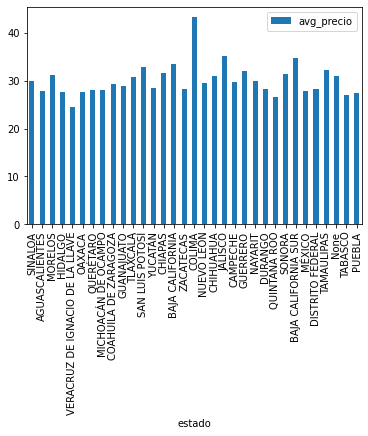

Producto: FRIJOLES


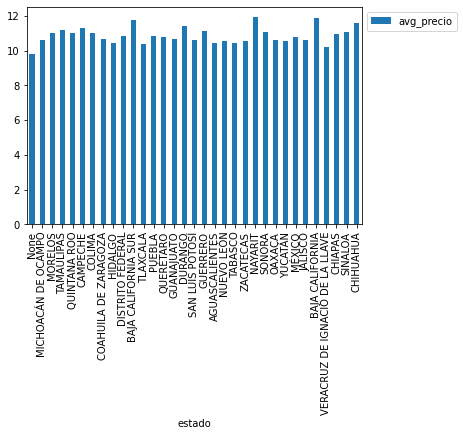

Producto: ARROZ


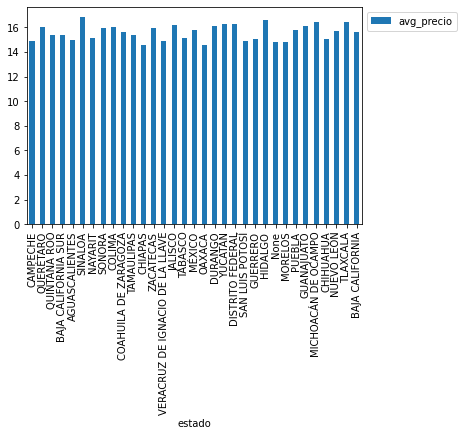

In [22]:
plt.figure(figsize=(12,8))
for producto in pregunta_1.producto.unique():
    print(f'Producto: {producto}')    
    pregunta_1[pregunta_1.producto==producto].plot(x='estado', y='avg_precio',kind='bar')    
    plt.legend(bbox_to_anchor=(1, 1))    
    plt.show()

Solo por curiosidad vi el describe de los precios del huevo en Colima y no es por atípicos que el promedio haya salido caro, en efecto el huevo esta caro en Colima

In [27]:
data.filter((data.producto=='HUEVO') & (data.estado=='COLIMA')).select(F.col('precio')).summary().show()

+-------+-----------------+
|summary|           precio|
+-------+-----------------+
|  count|             1983|
|   mean|43.31081190115985|
| stddev|16.43547140728973|
|    min|            16.65|
|    25%|             27.4|
|    50%|             39.5|
|    75%|             60.5|
|    max|             83.5|
+-------+-----------------+



#### Precio promedio de canasta básica por año

In [28]:
data.agg({"fechaRegistro": "min"}).collect()[0]

Row(min(fechaRegistro)='2011-01-03 00:00:00.000')

In [29]:
data.agg({"fechaRegistro": "max"}).collect()[0]

Row(max(fechaRegistro)='2014-12-26 00:00:00.000')

In [30]:
pregunta_1_2 = (data.filter(data.producto.isin(canasta_basica))
                .select(F.year("fechaRegistro").alias('anio_fecha_registro'), 'producto', 'precio')
                .groupby('producto', 'anio_fecha_registro').agg(F.avg('precio').alias('avg_precio')).toPandas())

Producto: ARROZ


<Figure size 864x576 with 0 Axes>

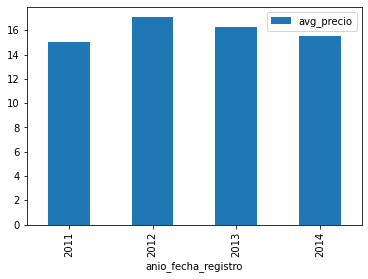

Producto: FRIJOLES


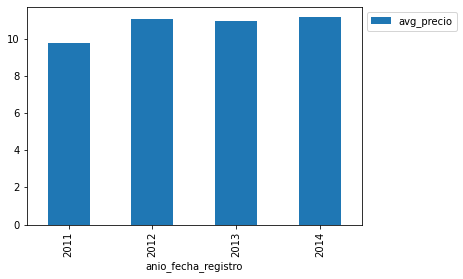

Producto: HUEVO


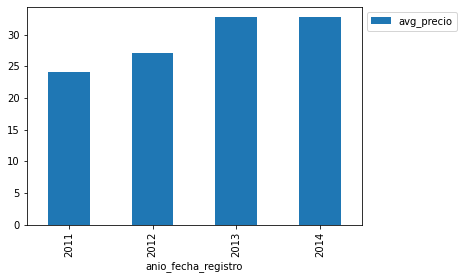

In [32]:
plt.figure(figsize=(12,8))
for producto in pregunta_1_2.producto.unique():
    print(f'Producto: {producto}')    
    pregunta_1_2[pregunta_1_2.producto==producto].sort_values(by='anio_fecha_registro').plot(x='anio_fecha_registro', y='avg_precio',kind='bar')    
    plt.legend(bbox_to_anchor=(1, 1))    
    plt.show()

### ¿Cuál es la ciudad más cara del país? ¿Cuál es la más barata?

Para simplificar esta  respuesta, utilizaremos la misma canasde productos basicos creada en la pregunta anterior. La ciudad más cara del pais sera aquella en la cual la suma del precio promedio de estos 3 productos sea mayor.

Nota: Entiendo que la pregunta dice ciudad, sin embargo ya no me dara tiempo de obtener la ciudad a partir de las coordenadas, por lo que usaré el municipio

In [33]:
pregunta_2 = (data.filter(data.producto.isin(canasta_basica)).groupby('producto', 'municipio')
              .agg(F.avg('precio').alias('avg_precio'))
              .groupby('municipio').agg(F.sum('avg_precio').alias('precio_prom_canasta_basica')).toPandas())

De acuerdo a este análisis el municipio en el que la canasta básica es en promedio más cara es Colima. Aunque por la respuesta a la pregunta 1, sabemos que es por el huevo 

In [34]:
pregunta_2[pregunta_2.precio_prom_canasta_basica==pregunta_2.precio_prom_canasta_basica.max()]

,municipio,precio_prom_canasta_basica
15,COLIMA,70.40


### ¿Hay algún patrón estacional entre años?

In [35]:
pregunta_3 = (data.filter(data.producto.isin(canasta_basica))
                .select(F.month("fechaRegistro").alias('mes_fecha_registro'),
                        F.year("fechaRegistro").alias('anio_fecha_registro'),'producto', 'precio')
                .groupby('producto', 'anio_fecha_registro', 'mes_fecha_registro')
              .agg(F.avg('precio').alias('avg_precio'))
              .groupby('anio_fecha_registro', 'mes_fecha_registro')
              .agg(F.sum('avg_precio').alias('precio_prom_canasta_basica'))
              .toPandas()
             )

In [38]:
pregunta_3['anio_mes'] = pregunta_3.apply(lambda x: datetime(int(x['anio_fecha_registro']), int(x['mes_fecha_registro']), 1),axis=1)

Para el precio promedio de la canasta básica se observa que de 2011 a 2013 los precios suben entre Julio y Enero y luego de Enero a Julio los precios bajan. Posterior a 2013 no se observa un patrón claro

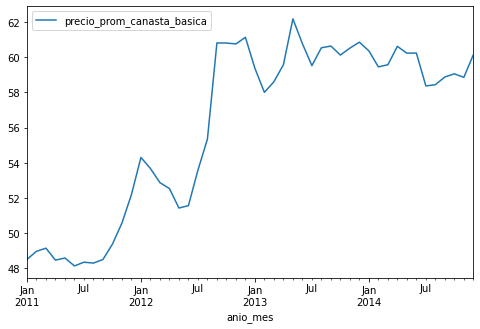

In [39]:
ax = pregunta_3.sort_values('anio_mes').plot(x='anio_mes', y ='precio_prom_canasta_basica',figsize=(8,5))
plt.show()

### ¿Cuál es el estado más caro y en qué mes?

Siguiendo la línea de la canasta básica determinaremos el estado más caro de acuerdo a los precios de la canasta básica y después analizaremos para que mes es más caro

In [40]:
pregunta_4 = (data.filter(data.producto.isin(canasta_basica)).groupby('producto', 'estado')
              .agg(F.avg('precio').alias('avg_precio'))
              .groupby('estado').agg(F.sum('avg_precio').alias('precio_prom_canasta_basica')).toPandas())

No es sorpresa que el estado más caro sea Colima, dada la selección que se hizo de la canasta básica

In [44]:
pregunta_4[pregunta_4.precio_prom_canasta_basica==pregunta_4.precio_prom_canasta_basica.max()]

,estado,precio_prom_canasta_basica
31,COLIMA,70.36


In [45]:
pregunta_4_2 = (data.filter((data.producto.isin(canasta_basica)) & (data.estado=='COLIMA'))
 .select(F.month("fechaRegistro").alias('mes_fecha_registro'), 'producto', 'precio')
 .groupby('producto', 'mes_fecha_registro')
 .agg(F.avg('precio').alias('avg_precio'))
 .groupby('mes_fecha_registro')
 .agg(F.sum('avg_precio').alias('precio_prom_canasta_basica'))
 .toPandas())

El estado más caro es Colima en el mes de Mayo

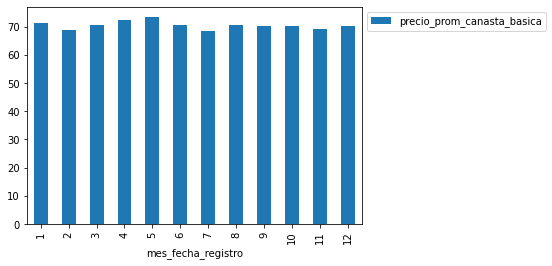

In [46]:
pregunta_4_2.sort_values('mes_fecha_registro').plot(x='mes_fecha_registro', y='precio_prom_canasta_basica', kind='bar')
plt.legend(bbox_to_anchor=(1, 1))

### ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con estos datos?

De acuerdo a los resultados de la pregunta 2.3 la serie no es homoscedástica y además tiene tendencia creciente pero no es monotona; se ven caídas bastante fuertes. Este tipo de problemas se pueden corregir con técnicas utilizadas para modelar series de tiempo, sin embargo no aseguraría con la información que tengo hasta el momento que esto sería  la mejor opción.

## Visualización


Se me acabo el tiempo para resolver esta sección